## **Projeto Final**: Aprendizado de Máquina MC886

# **Detecção de Comentários Tóxicos em Português do Brasil:** Bertimbau

Universidade de Campinas (UNICAMP), Instituto da Computação (IC)

Prof. Sandra Avila, 2s2020

**Grupo**:
- Eduardo Barros Innarelli (170161)
- João Pedro Congio Martins (176117)
- Pedro Alan Tapia Ramos (185531)

---

Se você estiver usando o Google Colab, conecte com o Google Drive para ter acesso aos datasets:

In [1]:
from google.colab import drive

# Isso solicitará autorização
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# Vá até a pasta do projeto (depende da onde está salva no seu Drive)
% cd '/content/drive/My Drive/[MC886] Projeto Final/'
! ls

/content/drive/My Drive/[MC886] Projeto Final
bertimbau.ipynb		 docs	     nbsvm_baseline.ipynb  __pycache__
build_nbsvm_pipeline.py  model_save  nbsvm-model.joblib    split_dataset.py
data			 nbsvm	     pretrained-bert	   tokenizer.py


---

## **Dependências**

In [3]:
# Instalar a lib transformers
!pip install transformers

In [31]:
# Bibliotecas utilizadas
import os
import random
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Pacotes de pré-processamento e treinamento
import torch
from torch.utils.data import (TensorDataset, DataLoader, RandomSampler, 
                              SequentialSampler, random_split)
from transformers import (BertTokenizer, BertForSequenceClassification, AdamW, 
                          BertConfig, get_linear_schedule_with_warmup)

In [5]:
# Pedir para pytorch usar a GPU, se possível
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


## **Pré-processamento**

Usamos a mesma estratégia do artigo base de agregar as classes de ofensa em uma única e classificar um tweet como tóxico se ao menos uma pessoa o anotou como tal em alguma das categorias.

> "In this paper, we consider the least restrictive case,
where if at least one annotator marked any offence
category in an example, the example is positive for
toxicity. Likewise, if a tweet was not tagged in any
of these categories, it is considered non-toxic. We
believe that it is essential that if any person feels
uncomfortable with a post, it should be flagged as
having a certain degree of toxicity. Therefore, a
model built with this data must be able to identify
offensive posts, even for a specific group of people."


In [6]:
# Carregar dataset
told_br = pd.read_csv("data/ToLD-BR.csv")

# Agregar classes de comentários ofensivos
told_br['label'] = told_br[['homophobia', 
                            'obscene',
                            'insult',
                            'misogyny',
                            'xenophobia']].agg('sum', axis=1)

# Converter em classificação binária (1 é tóxico, 0 não é tóxico)
told_br.loc[told_br['label'] >= 1, 'label'] = 1

# Salvar em arrays numpy
texts = told_br.text.values
labels = told_br.label.values

O texto a ser enviado para o BERT deve ser dividido em tokens. O tokenizador do BERT já trata de incluir os tokens especiais que o modelo requere, de mapear os tokens e de truncar os textos. 

In [7]:
# Carregar tokenizer
tokenizer = BertTokenizer.from_pretrained('pretrained-bert', do_lower_case=True)

In [8]:
input_ids = []
attention_masks = []

for text in texts:
  # `encode_plus` vai:
  #   (1) Tokenizar o texto.
  #   (2) Prefixar o token `[CLS]` no início.
  #   (3) Anexar o token `[SEP]` no fim.
  #   (4) Mapear cada token ao seu ID.
  #   (5) Truncar ou preencher o texto até `max_length`.
  #   (6) Criar máscaras de atenção para tokens [PAD].
  encoded_dict = tokenizer.encode_plus(
                    text,
                    add_special_tokens = True,   
                    max_length = 188, # maior texto tem 188 tokens
                    padding = 'max_length',
                    return_attention_mask = True,
                    return_tensors = 'pt',
                )
  
  # Adicionar tokens codificados
  input_ids.append(encoded_dict['input_ids'])

  # Adicionar máscaras de atenção (diferencia padding de não padding)
  attention_masks.append(encoded_dict['attention_mask'])

# Converter listas em tensores
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Imprimir texto 0 como sequência de ID's
print('Original: ', texts[0])
print('Token IDs:', input_ids[0])

Original:  Meu nivel de amizade com isis é ela ter meu insta e eu ter o dela, e quando eu penso que não ela manda mensagem “ falano otario ta falando dnv no insta”
Token IDs: tensor([  101,  7343,   149,  4812,   125,  8286,   170,   847,   145,   122,
          740,   370,  7343,  2861,   122,  2779,   370,   146,  3914,   117,
          122,   625,  2779,  4174, 22280,   179,   229, 22280,   740,  3497,
         6947,  1112,  3887,   300,   146,   578,   247,   316, 12402,   121,
        22285, 22292,   202,  2861, 22354,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,   

Agora, dividimos o dataset em treino, validação e teste.


In [9]:
# Combinar inputs em um TensorDataset
dataset = TensorDataset(input_ids, attention_masks, labels)

# Calcular número de exemplos que cada divisão terá
train_size = int(0.8 * len(dataset)) # 80%
val_size = int(0.1 * len(dataset)) # 10%
test_size = val_size # 10%

# Divide dataset aleatoriamente
train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('{:>5,} test samples'.format(test_size))

16,800 training samples
2,100 validation samples
2,100 test samples


Finalmente, iterator são criados para os conjuntos de treino, validação e teste usando a classe `DataLoader`. Isso ajuda a economizar memória durante o treinamento, pois evita com que todo o dataset seja carregado na memória ao contrário de um loop comum. 

In [10]:
# O DataLoader precisa saber o tamanho do batch de treinamento, então 
# especificamos aqui. Para treinar o BERT em uma tarefa específica, os autores
# recomendam um tamanho de 16 ou 32.
batch_size = 16

# Criar DataLoader para conj. de treino
train_dataloader = DataLoader(
  train_dataset,
  sampler = RandomSampler(train_dataset), # selecionar aleatoriamente
  batch_size = batch_size
)

# Criar DataLoader para conj. de validação
validation_dataloader = DataLoader(
  val_dataset, 
  sampler = SequentialSampler(val_dataset), # selecionar sequencialmente
  batch_size = batch_size
)

# Criar DataLoader para conj. de teste
test_dataloader = DataLoader(
  test_dataset, 
  sampler = SequentialSampler(test_dataset), # selecionar sequencialmente
  batch_size = batch_size
)

## **Treinamento**

A biblioteca `transformers` inclui uma série de interfaces projetadas para diferentes tarefas de ILP. Usamos a classe `BertForSequenceClassification`, que inclui uma camada de classificação no modelo BERT pré-treinado passado por parâmetro, no nosso caso o BERTimbau. Assim, carregamos o modelo e instanciamos alguns hiperparâmetros.

In [11]:
# Carregar modelo
model = BertForSequenceClassification.from_pretrained(
    "pretrained-bert",
    num_labels = 2,
    output_attentions = False, 
    output_hidden_states = False,
)

# Treinar modelo na GPU
model.cuda()

Some weights of the model checkpoint at pretrained-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at p

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [12]:
# Instanciar otimizador da descida do gradiente
optimizer = AdamW(
  model.parameters(),
  lr = 2e-3, # taxa de aprendizado
  eps = 1e-8 # para estabilidade numérica
)

# Autores recomendam 2-4 épocas (> 2 overfitou)
epochs = 2

# Número de iterações é [nº de batches] x [nº de épocas]. 
total_steps = len(train_dataloader) * epochs

# Criar scheduler para lr
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

Antes de treinar, definimos algums funções úteis que serão usadas no processo.

In [14]:
def flat_accuracy(preds, labels):
  '''
  Função para calcular acurácia das predições.
  '''
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
  '''
  Recebe o tempo em segundos e retorna uma string hh:mm:ss
  '''
  elapsed_rounded = int(round((elapsed)))
  return str(datetime.timedelta(seconds=elapsed_rounded))

Agora estamos prontos para rodar o treinamento.

**ATENÇÃO:** evite rodar esta célula caso o modelo já tenha sido treinado! Carregue do arquivo nas próximas células ou re-treine com os melhores hiperparâmetros encontrados. 

In [15]:
# Tornar treinamento reprodutível
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Custo, acurácia, tempo...
training_stats = []

# Tempo total de execução
total_t0 = time.time()

for epoch_i in range(0, epochs):
    
    # ========================================
    #                 Treino
    # ========================================
    # "Full pass" no conjunto de treino

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Quanto dura a época
    t0 = time.time()

    # Resetar custo
    total_train_loss = 0

    # Modo de treinamento (não confundir com treinamento em si)
    model.train()

    for step, batch in enumerate(train_dataloader):

        # Mostrar progresso a cada 40 batches
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(
                step, len(train_dataloader), elapsed))

        # Destacar ids, máscaras e labels do batch
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device=device, dtype=torch.int64)

        # Limpar gradientes
        model.zero_grad()        

        # "Forward pass"
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels,
                             return_dict=False)
        
        # Acumular custos para calcular a média
        total_train_loss += loss.item()

        # "Backward pass"
        loss.backward()

        # Normalizar para evitar com que gradientes explodam
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Atualizar parâmetros
        optimizer.step()
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validação
    # ========================================
    # Medir desempenho no conjunto de validação

    print("")
    print("Running Validation...")

    # Quanto dura a validação
    t0 = time.time()

    # Modo de avaliação
    model.eval()

    # Acumular para todos os batches 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:
        
        # Destacar ids, máscaras e labels do batch
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device=device, dtype=torch.int64)
        
        # Não computar gradientes
        with torch.no_grad():        

            # Predizer
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels,
                                   return_dict=False)
            
        # Acumular custo
        total_eval_loss += loss.item()

        # Mover predições e labels para CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Acumular acurácia para esse batch
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    # Acurácia da validação
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Média do custo
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Tempo da validação
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Armazenar estatísticas
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(
    format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...
  Batch    40  of  1,050.    Elapsed: 0:00:38.
  Batch    80  of  1,050.    Elapsed: 0:01:15.
  Batch   120  of  1,050.    Elapsed: 0:01:53.
  Batch   160  of  1,050.    Elapsed: 0:02:31.
  Batch   200  of  1,050.    Elapsed: 0:03:09.
  Batch   240  of  1,050.    Elapsed: 0:03:47.
  Batch   280  of  1,050.    Elapsed: 0:04:25.
  Batch   320  of  1,050.    Elapsed: 0:05:03.
  Batch   360  of  1,050.    Elapsed: 0:05:40.
  Batch   400  of  1,050.    Elapsed: 0:06:18.
  Batch   440  of  1,050.    Elapsed: 0:06:56.
  Batch   480  of  1,050.    Elapsed: 0:07:34.
  Batch   520  of  1,050.    Elapsed: 0:08:12.
  Batch   560  of  1,050.    Elapsed: 0:08:50.
  Batch   600  of  1,050.    Elapsed: 0:09:27.
  Batch   640  of  1,050.    Elapsed: 0:10:05.
  Batch   680  of  1,050.    Elapsed: 0:10:43.
  Batch   720  of  1,050.    Elapsed: 0:11:21.
  Batch   760  of  1,050.    Elapsed: 0:11:59.
  Batch   800  of  1,050.    Elapsed: 0:12:37.
  Batch   840  of

Para evitar treinar novamente, salvamos o modelo no drive.

In [18]:
output_dir = './trained-bert/'

# Criar pasta se preciso
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Salvar modelo treinado
model_to_save = model.module if hasattr(model, 'module') else model 
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to ./trained-bert/


('./trained-bert/tokenizer_config.json',
 './trained-bert/special_tokens_map.json',
 './trained-bert/vocab.txt',
 './trained-bert/added_tokens.json')

## **Avaliação**

Primeiro, carregamos o modelo salvo na pasta `trained-bert`.

In [19]:
output_dir = './trained-bert/'

# Carregar modelo e vocabulário treinado
model = BertForSequenceClassification.from_pretrained(output_dir)
tokenizer = BertTokenizer.from_pretrained(output_dir)

# Copiar o modelo na GPU
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

Utilizamos o modelo treinado para computar as predições no conjunto de teste e avaliar como o modelo generaliza.

In [32]:
# Modo de avaliação
model.eval()

# Armazenar predições 
predictions , true_labels = [], []

for batch in test_dataloader:
  batch = tuple(t.to(device) for t in batch)
  
  # Destacar ids, máscaras e labels do batch
  b_input_ids, b_input_mask, b_labels = batch
  
  with torch.no_grad():
      # "Forward pass"
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Mover predições e labels p/ cpu
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Armazenar predições e labels
  predictions.append(logits)
  true_labels.append(label_ids)

# Converter predições e labels em arrays com 0s e 1s
flat_predictions = np.concatenate(predictions, axis=0)
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = np.concatenate(true_labels, axis=0)

# Mostrar métricas
print(classification_report(flat_true_labels, flat_predictions))

              precision    recall  f1-score   support

         0.0       0.86      0.76      0.80      1219
         1.0       0.71      0.83      0.76       881

    accuracy                           0.79      2100
   macro avg       0.78      0.79      0.78      2100
weighted avg       0.80      0.79      0.79      2100



Finalmente, plotamos a matriz de confusão para termos uma visão melhor dos acertos e erros do modelo treinado.

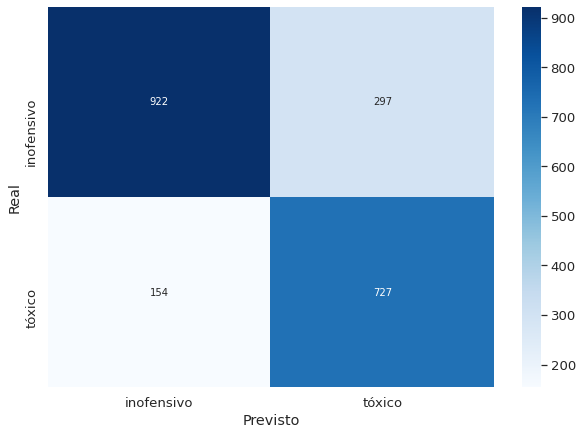

In [33]:
# Construir matriz de confusão com scikit-learn
cmatrix = confusion_matrix(flat_true_labels, flat_predictions)

# Salvar matriz como um dataframe do pandas
labels = ['inofensivo', 'tóxico']
df_cm = pd.DataFrame(cmatrix, columns=labels, index=labels)
df_cm.index.name = 'Real'
df_cm.columns.name = 'Previsto'

# Plotar como um mapa de calor
plt.figure(figsize = (10,7))
sns.set(font_scale=1.2)
sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 10}, fmt='g');